<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<div>Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений..</div><br>
<div>Отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.</div><br>
    <div>Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».</div><br>
     <div>Нужно собрать данные по клиентам по следующим группам: </div>
<li>Признаки, которые описывают коммуникацию сотрудников компании с клиентом.</li>
<li>Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.</li>
<li>Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
</li>
<li>Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.</li>
</div>

In [1]:
! pip install shap -q # -q убирает необязательные выводы в командах Linux
! pip install phik

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import shapiro
import seaborn as sns
import shap
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## Загрузка данных

In [3]:
data_market = pd.read_csv('/datasets/market_file.csv')
data_market_money = pd.read_csv('/datasets/market_money.csv')
data_time = pd.read_csv('/datasets/market_time.csv')
data_money = pd.read_csv('/datasets/money.csv', sep=';',decimal=",")

In [4]:
data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [5]:
data_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Оставили разделитель только там, где это необходимо
</div>

In [6]:
data_market.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [7]:
data_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [8]:
data_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
data_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


##  Предобработка данных

In [10]:
def columns_rename(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(', ', ' ',regex=True)
    df.columns = df.columns.str.replace(',', ' ',regex=True)
    df.columns = df.columns.str.replace(' ', '_',regex=True)
    df.info()

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Написали функцию для переименования столбцов 
</div>

In [11]:
columns_rename(data_market)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [12]:
columns_rename(data_market_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [13]:
columns_rename(data_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [14]:
columns_rename(data_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Переименовали столбцы, переходим к предобработке данных
</div>

In [15]:
data_market.isnull().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [16]:
data_market.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [17]:
data_market['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [18]:
data_market['покупательская_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [19]:
data_market = data_market.apply(lambda x: x.replace({'стандартт':'стандарт',}, regex=True))
data_market['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [20]:
data_market['покупательская_активность'] = data_market['покупательская_активность'].str.lower()
data_market['популярная_категория'] = data_market['популярная_категория'].str.lower()

In [21]:
data_market.duplicated().sum()

0

In [22]:
data_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [23]:
data_market['покупательская_активность'] =  data_market['покупательская_активность'].map({'прежний уровень': True, 'снизилась': False}) 
data_market['покупательская_активность'].unique()

array([False,  True])

In [24]:
data_market['маркет_актив_6_мес'] = data_market['маркет_актив_6_мес'].astype (float)
data_market['акционные_покупки'] = data_market['акционные_покупки'].astype (float)
data_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   bool   
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [25]:
data_market_money.isnull().sum()

id         0
период     0
выручка    0
dtype: int64

In [26]:
data_market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [27]:
data_market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [28]:
data_market_money = data_market_money.apply(lambda x: x.replace({'препредыдущий_месяц':'препредыдущий месяц', 'предыдущий_месяц':'предыдущий месяц', 'текущий_месяц':'текущий месяц'}, regex=True))
data_market_money['период'].unique()

array(['препредыдущий месяц', 'текущий месяц', 'предыдущий месяц'],
      dtype=object)

In [29]:
data_market_money.duplicated().sum()

0

In [30]:
data_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [31]:
data_market_money['выручка'] = data_market_money['выручка'].astype (float)
data_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [32]:
data_time.isnull().sum()

id        0
период    0
минут     0
dtype: int64

In [33]:
data_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [34]:
data_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [35]:
data_time = data_time.apply(lambda x: x.replace({'предыдцщий_месяц':'предыдущий месяц', 'предыдущий_месяц':'предыдущий месяц','текущий_месяц':'текущий месяц'}, regex=True))
data_time['период'].unique()

array(['текущий месяц', 'предыдущий месяц'], dtype=object)

In [36]:
data_time.duplicated().sum()

0

In [37]:
data_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [38]:
data_money.isnull().sum()

id         0
прибыль    0
dtype: int64

In [39]:
data_money.duplicated().sum()

0

In [40]:
data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Провели предобработку всех данных
</div>

## Исследовательский анализ данных

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
нам необходимо оставить только клиентов с активностью в 3 месяца, для этого идеально подходит таблица data_market_money, из-за ее значений периода (как раз 3 последних значений месяца), т.е нам необходимо убрать всех клиентов, у кого нет трат хотя бы в один из этих месяцов
</div>

In [41]:
id_active = data_market_money[data_market_money['выручка'] == 0]['id'].unique()
id_active

array([215348, 215357, 215359])

In [42]:
for i in id_active:
       data_market_money = data_market_money[data_market_money.id != i]

In [43]:
data_market_money[data_market_money['выручка'] == 0]

,id,период,выручка


In [44]:
def draw_grafic(columns,data):
    for i in columns:
        data[i].hist(bins=50, figsize=(10, 5), grid=True);
        plt.xlabel(i)
        plt.ylabel('Частота')
        plt.title(i)
        plt.show()
        data[i].plot(kind='box')
        plt.ylabel(i)
        plt.title(i)
        plt.show()
        stat, p_val = shapiro(data[i])
        if p_val < 0.5: print(i +' не нормальное')
        else: print(i +' нормальное')

   

In [45]:
data_market_money.describe(include = 'all').style.background_gradient('coolwarm')

,id,период,выручка
count,3891.000000,3891,3891.000000
unique,nan,3,nan
top,nan,препредыдущий месяц,nan
freq,nan,1297,nan
mean,215998.986893,nan,5033.718890
std,374.482249,nan,1768.471286
min,215349.000000,nan,2758.700000
25%,215675.000000,nan,4592.000000
50%,215999.000000,nan,4959.000000
75%,216323.000000,nan,5363.200000


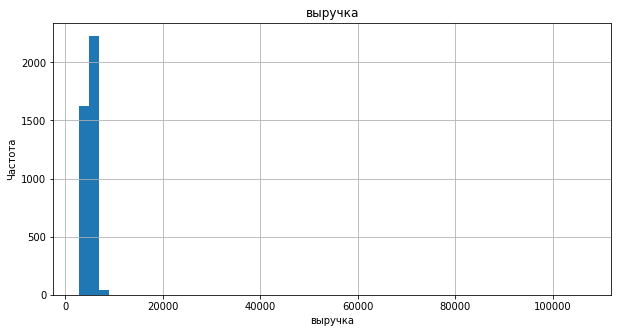

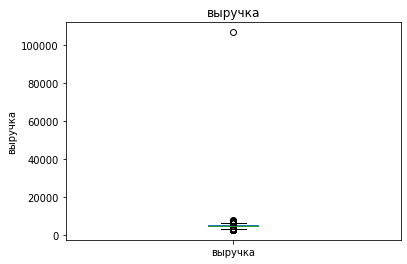

выручка не нормальное


In [46]:
col = ['выручка']
draw_grafic(col, data_market_money)

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Добавили подпись к осям
</div>

In [47]:
data_market_money[data_market_money['выручка'] == data_market_money['выручка'].max()]

,id,период,выручка
98,215380,текущий месяц,106862.2


In [48]:
id_active = np.append(id_active, 215380)
data_market_money = data_market_money[data_market_money.id != 215380]

In [49]:
data_market_money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3888 entries, 3 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3888 non-null   int64  
 1   период   3888 non-null   object 
 2   выручка  3888 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.5+ KB


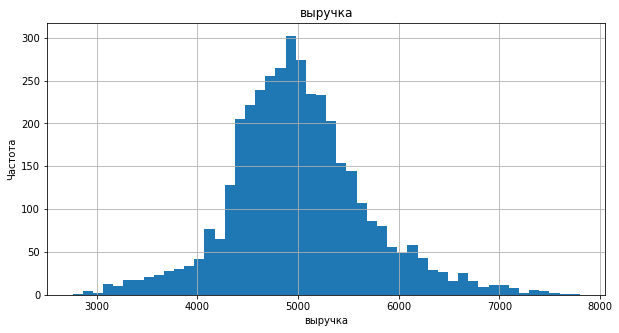

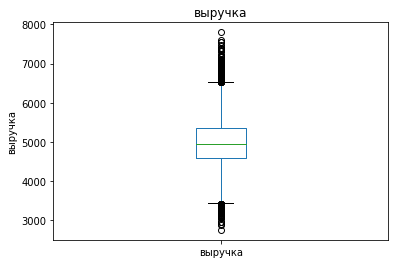

выручка не нормальное


In [50]:
draw_grafic(col, data_market_money)

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
удалили одного клиента с явным выбросом, чтобы данные были качественнее
</div>

In [51]:
for i in id_active:
       data_market = data_market[data_market.id != i]

In [52]:
data_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   bool   
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

In [53]:
data_market.describe(include = 'all').style.background_gradient('coolwarm')

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1296.000000,1296,1296,1296,1296.000000,1296.000000,1296.000000,1296.000000,1296,1296.000000,1296.000000,1296.000000,1296.000000
unique,nan,2,2,2,nan,nan,nan,nan,6,nan,nan,nan,nan
top,nan,True,стандарт,да,nan,nan,nan,nan,товары для детей,nan,nan,nan,nan
freq,nan,802,922,959,nan,nan,nan,nan,329,nan,nan,nan,nan
mean,215999.464506,nan,nan,nan,4.256404,4.009259,602.967593,0.320069,nan,3.267747,2.841821,4.184414,8.187500
std,374.327860,nan,nan,nan,1.013525,0.696316,249.195823,0.249159,nan,1.355125,1.974074,1.951719,3.978459
min,215349.000000,nan,nan,nan,0.900000,3.000000,121.000000,0.110000,nan,1.000000,0.000000,0.000000,1.000000
25%,215675.750000,nan,nan,nan,3.700000,4.000000,409.500000,0.170000,nan,2.000000,1.000000,3.000000,5.000000
50%,215999.500000,nan,nan,nan,4.200000,4.000000,606.500000,0.240000,nan,3.000000,3.000000,4.000000,8.000000
75%,216323.250000,nan,nan,nan,4.900000,4.000000,806.250000,0.300000,nan,4.000000,4.000000,6.000000,11.000000


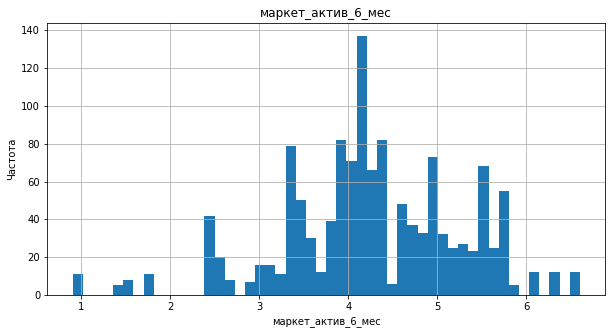

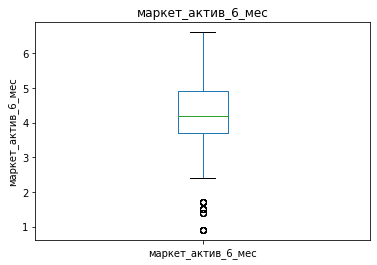

маркет_актив_6_мес не нормальное


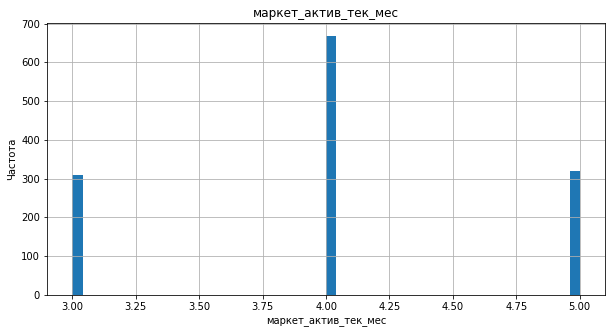

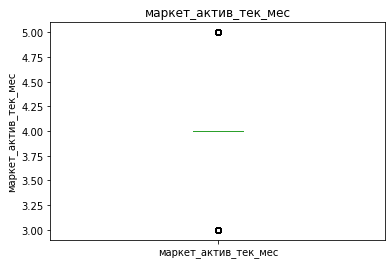

маркет_актив_тек_мес не нормальное


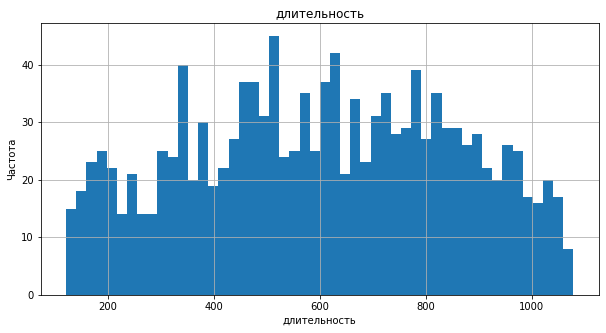

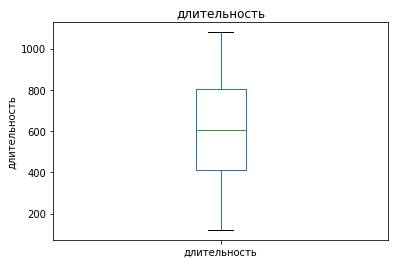

длительность не нормальное


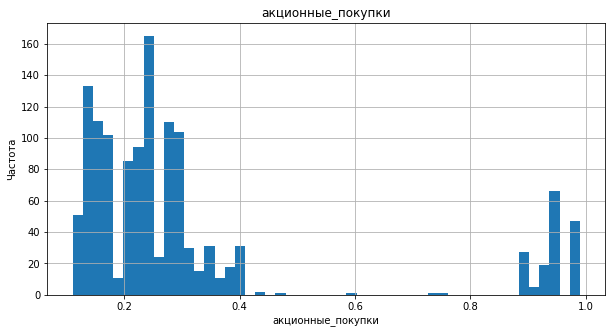

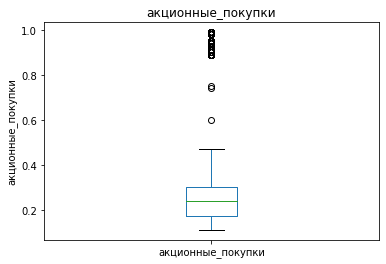

акционные_покупки не нормальное


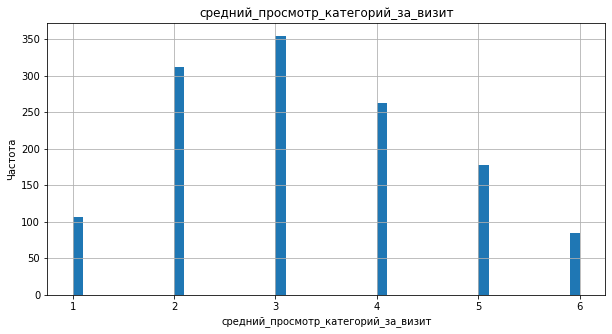

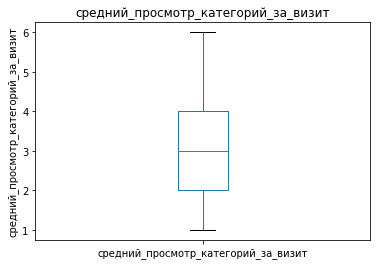

средний_просмотр_категорий_за_визит не нормальное


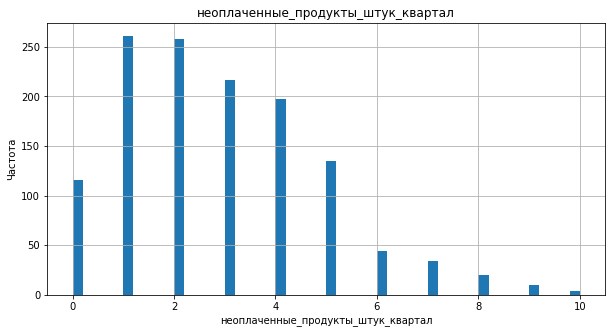

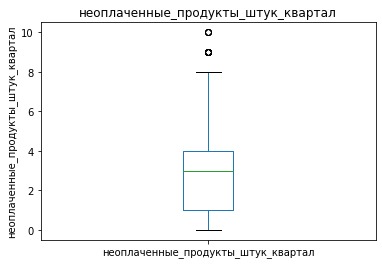

неоплаченные_продукты_штук_квартал не нормальное


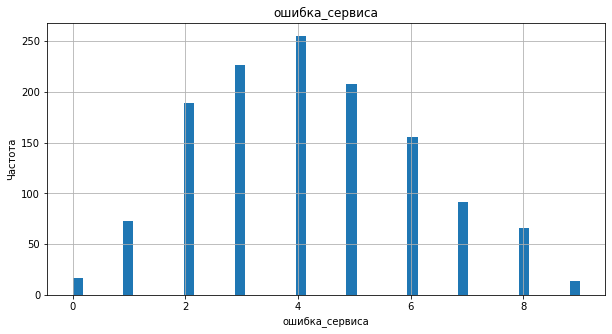

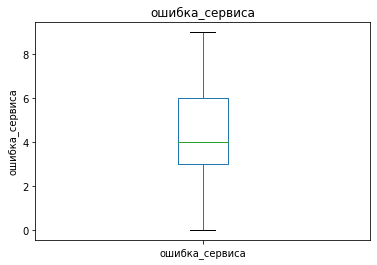

ошибка_сервиса не нормальное


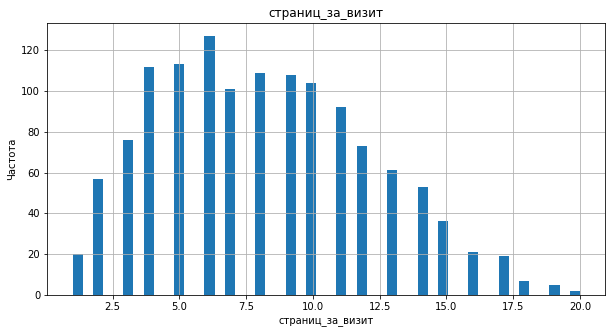

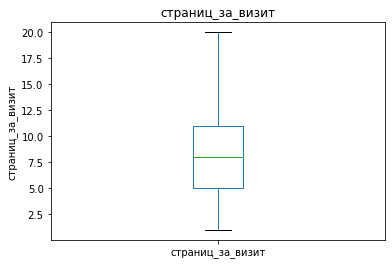

страниц_за_визит не нормальное


In [54]:
col = ['маркет_актив_6_мес','маркет_актив_тек_мес','длительность','акционные_покупки','средний_просмотр_категорий_за_визит'
      ,'неоплаченные_продукты_штук_квартал','ошибка_сервиса','страниц_за_визит']
draw_grafic(col, data_market)

In [55]:
for i in id_active:
       data_time = data_time[data_time.id != i]

In [56]:
data_time.describe(include = 'all').style.background_gradient('coolwarm')

,id,период,минут
count,2592.000000,2592,2592.000000
unique,nan,2,nan
top,nan,предыдущий месяц,nan
freq,nan,1296,nan
mean,215999.464506,nan,13.340664
std,374.255617,nan,4.083469
min,215349.000000,nan,4.000000
25%,215675.750000,nan,10.000000
50%,215999.500000,nan,13.000000
75%,216323.250000,nan,16.000000


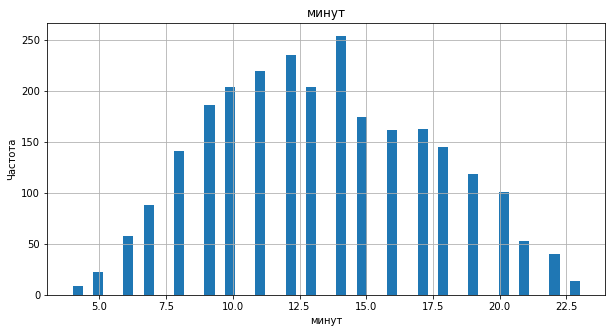

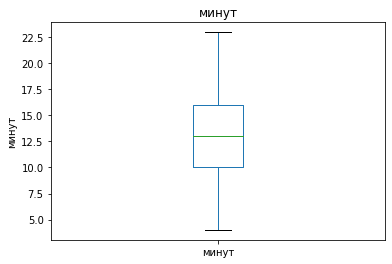

минут не нормальное


In [57]:
col = ['минут']
draw_grafic(col, data_time)

In [58]:
for i in id_active:
       data_money = data_money[data_money.id != i]

In [59]:
data_money.describe(include = 'all').style.background_gradient('coolwarm')

,id,прибыль
count,1296.000000,1296.000000
mean,215999.464506,3.997701
std,374.327860,1.011198
min,215349.000000,0.860000
25%,215675.750000,3.300000
50%,215999.500000,4.045000
75%,216323.250000,4.670000
max,216647.000000,7.430000


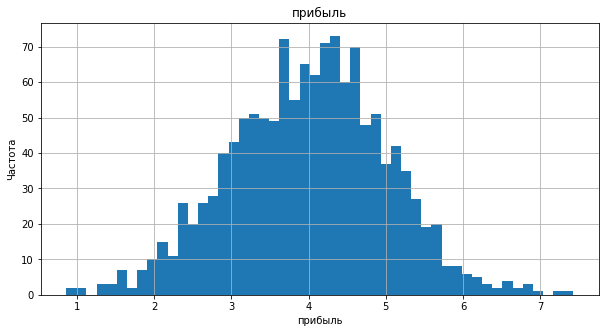

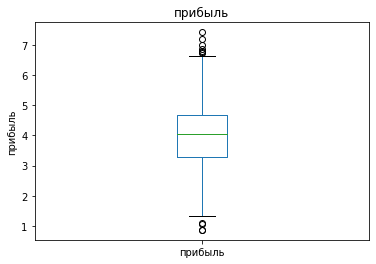

прибыль не нормальное


In [60]:
col = ['прибыль']
draw_grafic(col, data_money)

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Проверили все количественные признаки, исключил клиентов, которые не совершали покупки в 3 месяца и клиента с явным выбросом, более выбросов не наблюдается, везде наблюдается нормальное распределение, статистический анализ, так же не показал никаких проблем с данными
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
У всех признаков действительно наблюдается ненормальное распределение
</div>

In [61]:
def draw_grafic_cat(columns,data):
    for i in columns:
        data[i].value_counts().plot(kind='bar',)
        plt.xlabel(i)
        plt.ylabel('Количество')
        plt.show()

In [62]:
data_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   bool   
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

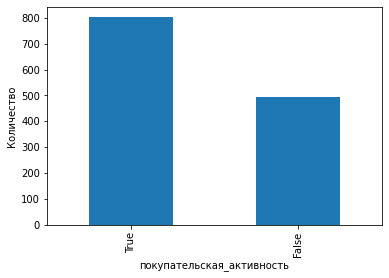

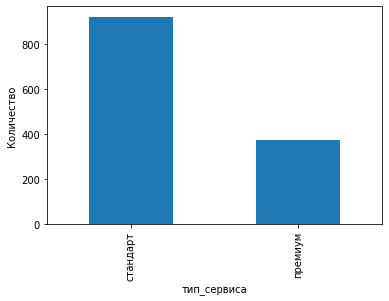

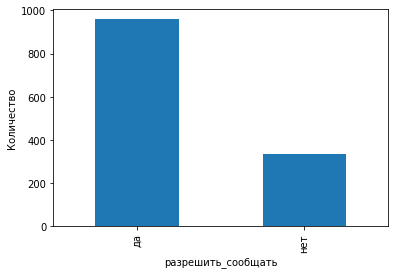

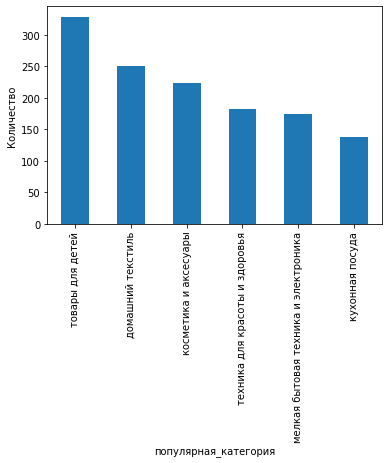

In [63]:
col = ['покупательская_активность','тип_сервиса','разрешить_сообщать','популярная_категория']
draw_grafic_cat(col, data_market)

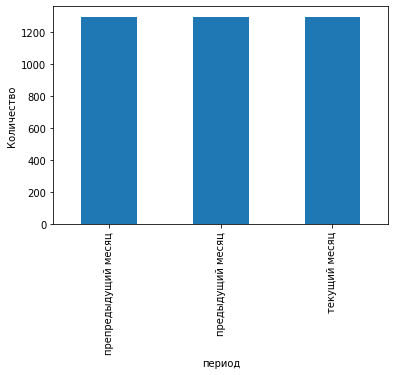

In [64]:
col = ['период']
draw_grafic_cat(col, data_market_money)

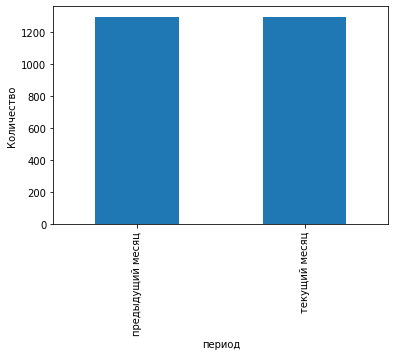

In [65]:
col = ['период']
draw_grafic_cat(col, data_time)

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
категориальные даныне так же впорядке, проблем нет
</div>

## Объединение таблиц

In [66]:
data_full = data_market.merge(data_money, on='id')

In [67]:
data_full.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,прибыль
0,215349,False,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,4.16
1,215350,False,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,3.13
2,215351,False,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,4.87
3,215352,False,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,4.21
4,215353,False,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,3.95


In [68]:
data_preprenow = data_market_money[data_market_money['период']== 'препредыдущий месяц']['выручка'].reset_index()
data_prenow = data_market_money[data_market_money['период']== 'предыдущий месяц']['выручка'].reset_index()
data_now = data_market_money[data_market_money['период']== 'текущий месяц']['выручка'].reset_index()

In [69]:
data_full['выручка_препредыдущий'] = data_preprenow['выручка']
data_full['выручка_предыдущий'] = data_prenow['выручка']
data_full['выручка_текущий'] = data_now['выручка']

In [70]:
data_full.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,прибыль,выручка_препредыдущий,выручка_предыдущий,выручка_текущий
0,215349,False,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,4.16,4472.0,5216.0,4971.6
1,215350,False,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,3.13,4826.0,5457.5,5058.4
2,215351,False,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,4.87,4793.0,6158.0,6610.4
3,215352,False,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,4.21,4594.0,5807.5,5872.5
4,215353,False,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,3.95,5124.0,4738.5,5388.5


In [71]:
data_prenow_min = data_time[data_time['период']== 'предыдущий месяц']['минут'].reset_index()
data_now_min = data_time[data_time['период']== 'текущий месяц']['минут'].reset_index()

In [72]:
data_full['минут_предыдущий'] = data_prenow_min['минут']
data_full['минут_текущий'] = data_now_min['минут']

In [73]:
data_full = data_full.drop(['id'], axis=1)
data_full.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,прибыль,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий,минут_текущий
0,False,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,4.16,4472.0,5216.0,4971.6,12,10
1,False,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,3.13,4826.0,5457.5,5058.4,8,13
2,False,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,4.87,4793.0,6158.0,6610.4,11,13
3,False,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,4.21,4594.0,5807.5,5872.5,8,11
4,False,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,3.95,5124.0,4738.5,5388.5,10,10


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Объединили таблицы согласно условиям по заданию, разбили выручку и минуту в отдельные столбы по периодам, прибыль просто соединили по id клиента
</div>

## Корреляционный анализ

In [74]:
data_full.corr(method="spearman").style.background_gradient('coolwarm')

,покупательская_активность,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,прибыль,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий,минут_текущий
покупательская_активность,1.000000,0.381839,0.003486,-0.061987,-0.469835,0.383275,-0.312748,0.113552,0.548059,0.002803,0.369509,-0.047946,-0.068327,0.515089,0.438834
маркет_актив_6_мес,0.381839,1.000000,0.061741,-0.044445,-0.276590,0.185013,-0.135045,0.038643,0.319872,-0.011866,0.234728,-0.003642,0.002093,0.273727,0.226968
маркет_актив_тек_мес,0.003486,0.061741,1.000000,-0.131967,0.033099,-0.025167,0.061747,0.087343,0.003143,-0.026523,-0.039437,-0.027088,-0.011782,0.013535,-0.063051
длительность,-0.061987,-0.044445,-0.131967,1.000000,0.029045,-0.043154,-0.108787,0.103562,-0.034495,0.027949,-0.039301,0.013537,0.015002,-0.123940,0.083048
акционные_покупки,-0.469835,-0.276590,0.033099,0.029045,1.000000,-0.203401,0.198307,-0.051593,-0.370860,-0.036843,-0.269087,0.005184,0.022255,-0.332548,-0.275313
средний_просмотр_категорий_за_визит,0.383275,0.185013,-0.025167,-0.043154,-0.203401,1.000000,-0.251559,0.010034,0.267479,-0.039148,0.149742,-0.049460,-0.070716,0.148279,0.233369
неоплаченные_продукты_штук_квартал,-0.312748,-0.135045,0.061747,-0.108787,0.198307,-0.251559,1.000000,-0.098582,-0.165412,-0.003906,-0.249293,0.033434,0.061178,-0.183575,-0.214699
ошибка_сервиса,0.113552,0.038643,0.087343,0.103562,-0.051593,0.010034,-0.098582,1.000000,0.104482,0.029886,0.090152,0.035476,0.040477,0.196009,0.078074
страниц_за_визит,0.548059,0.319872,0.003143,-0.034495,-0.370860,0.267479,-0.165412,0.104482,1.000000,-0.021637,0.311675,-0.067610,-0.049964,0.450760,0.298120
прибыль,0.002803,-0.011866,-0.026523,0.027949,-0.036843,-0.039148,-0.003906,0.029886,-0.021637,1.000000,0.005954,-0.031636,-0.023754,0.008411,0.019190


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Добавили метод Спирмена сильная связь сохранилась только у 2 признаков
</div>

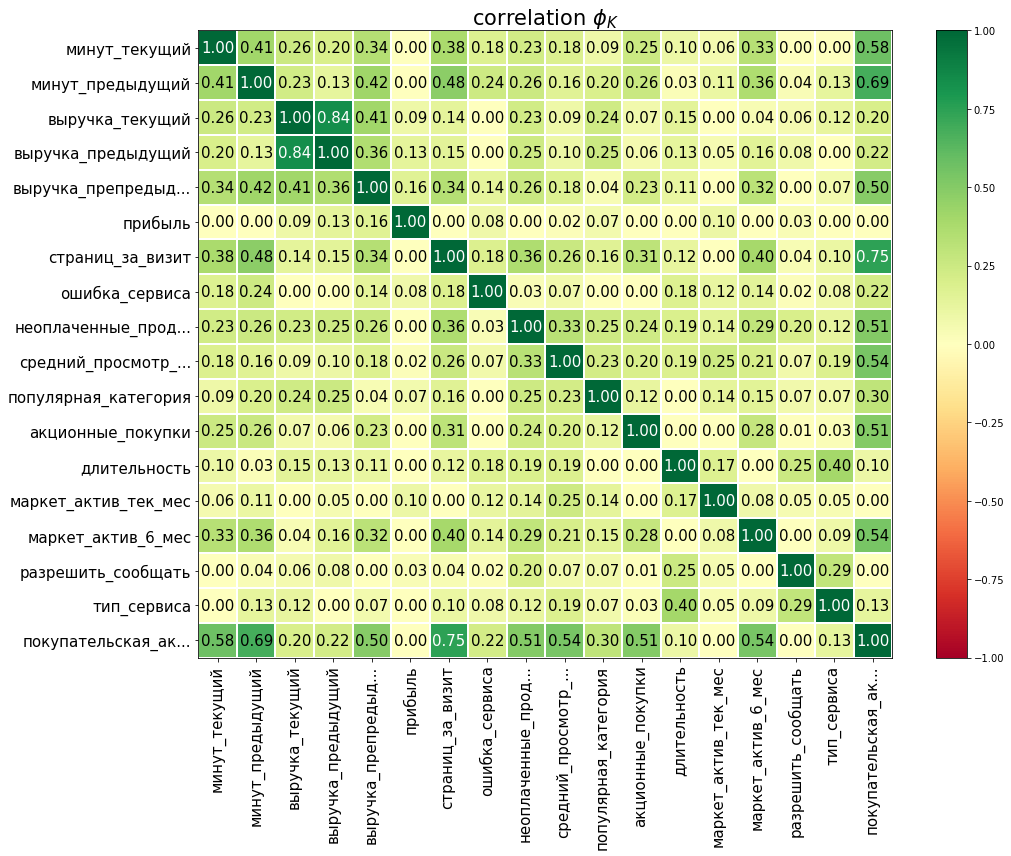

In [75]:
interval_cols = list(data_full.select_dtypes(['float','int']))

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = data_full.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

In [76]:
def scatterplot_draw (df, x , y, hue):
    for i in x:
        for j in y:
            for k in hue:
                if i != j:
                    sns.scatterplot(x=i, y=j, hue=k, data=df)
                    plt.show()
                else:
                    continue

In [77]:
x_values = data_full.select_dtypes(include='number').columns
y_values = x_values
hue = ['покупательская_активность', 'тип_сервиса','разрешить_сообщать','популярная_категория']

In [78]:
x_values

Index(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'прибыль', 'выручка_препредыдущий',
       'выручка_предыдущий', 'выручка_текущий', 'минут_предыдущий',
       'минут_текущий'],
      dtype='object')

In [79]:
#scatterplot_draw(data_full, x_values, y_values, hue)

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
графики подтверждают ранее созданную таблицу, тк видно, что на некоторых есть явная корреляция, на других нет вовсе, мультикорреляция не наблюдается
</div>

## Использование пайплайнов

In [80]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = data_full.drop(['покупательская_активность'], axis=1)
y = data_full['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [81]:
y_test

87      False
1223     True
1059     True
541      True
625      True
        ...  
637      True
201     False
99      False
666      True
430      True
Name: покупательская_активность, Length: 324, dtype: bool

In [82]:
X_train.shape, X_test.shape

((972, 17), (324, 17))

In [83]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   bool   
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит              

In [84]:
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса','разрешить_сообщать']
num_columns = x_values

In [115]:
x_values

Index(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'прибыль', 'выручка_препредыдущий',
       'выручка_предыдущий', 'выручка_текущий', 'минут_предыдущий',
       'минут_текущий'],
      dtype='object')

In [85]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
    )
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт'],
                    ['да', 'нет'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [86]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
    {
        'models': [SVC(kernel = 'linear', random_state=RANDOM_STATE,probability=True)],
        'models__degree': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


In [114]:
X_test

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,прибыль,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий,минут_текущий
0,премиум,нет,3.4,5,448,0.28,товары для детей,4,2,2,7,6.33,4551.0,5484.0,5833.7,9,9
1,премиум,да,4.5,4,482,0.25,косметика и аксесуары,3,2,2,9,1.82,5483.0,5567.0,5769.8,8,22
2,стандарт,да,5.1,4,602,0.23,товары для детей,2,2,8,9,3.26,4775.0,4857.0,4915.5,17,15
3,стандарт,нет,4.4,4,639,0.13,мелкая бытовая техника и электроника,2,4,2,10,3.16,5016.0,4936.5,4997.6,22,14
4,премиум,нет,3.5,5,161,0.14,кухонная посуда,2,1,5,8,4.02,5618.0,5693.0,5888.0,14,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,стандарт,да,4.7,4,529,0.24,мелкая бытовая техника и электроника,4,1,0,11,3.71,4982.0,6159.5,7310.0,20,20
320,стандарт,да,0.9,4,360,0.33,домашний текстиль,2,3,3,5,3.01,4309.0,4138.0,4594.3,6,10
321,стандарт,да,3.9,3,1048,0.22,товары для детей,4,5,4,5,5.31,4658.0,4043.0,4260.1,11,14
322,стандарт,нет,3.3,4,304,0.15,мелкая бытовая техника и электроника,5,3,4,5,3.59,4440.0,5005.5,5625.6,18,11


In [88]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent'...
    

In [89]:
y_test_pred = randomized_search.predict(X_test)
f1_score(y_test, y_test_pred)

0.9030732860520094

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Построили пайплайн, обучили модель, выбрали наилучшую, ею оказалась SVC с degree=1, в качестве метрики задали accuracy, тк нам важна точность модели в целом, начальное распределение столбца покупательская_активность примерно 60\40, нет большого уклона в какую либо сторону, поэтому для проверки точности метрика accuracy хорошо подходит
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Добавили номинальные признаки, ordinal encoder и поменяли метрику на f1 тк она менее чувствительна к порогам
</div>

## Анализ важности признаков

In [90]:
scaler = StandardScaler()
selector = SelectKBest(f_classif, k=16)
model = randomized_search.best_estimator_[1]
ohe_encoder  = OneHotEncoder(sparse=False,handle_unknown='ignore')
ord_encoder = OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт'],
                    ['да', 'нет'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )

In [91]:
X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_columns]) 
encoder_col_names_ohe = ohe_encoder.get_feature_names()
df_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names_ohe)

X_test_ohe = ohe_encoder.transform(X_test[ohe_columns]) 
df_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names_ohe)

X_test_ohe = ohe_encoder.transform(X_test[ohe_columns]) 
df_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names_ohe)

In [92]:
X_train.reset_index(drop = True,inplace= True )
X_test.reset_index(drop = True,inplace= True )

X_train_final = X_train.join(df_train_ohe)
X_test_final = X_test.join(df_test_ohe)

X_train_final.drop(ohe_columns, axis= 1 , inplace= True)
X_test_final.drop(ohe_columns, axis= 1 , inplace= True)

X_train_final[ord_columns] = ord_encoder.fit_transform(X_train[ord_columns])

X_test_final[ord_columns] = ord_encoder.transform(X_test[ord_columns])

In [93]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_final)
X_test_poly = poly.transform(X_test_final)

X_test_df = pd.DataFrame(X_test_poly,columns = poly.get_feature_names())

X_train_scalled = pd.DataFrame(scaler.fit_transform(X_train_poly),columns = poly.get_feature_names())
X_test_scalled =  pd.DataFrame(scaler.transform(X_test_poly),columns = poly.get_feature_names())
selector.fit(X_train_scalled, y_train)

features_names = X_train_scalled.columns[selector.get_support(indices=True)]
X_train_new = X_train_scalled[list(features_names)]
X_test_new = X_test_scalled[list(features_names)]

model.fit(X_train_new, y_train)
list(features_names)

Features [  0 256 257 258 259 260 262 263 264 265 267 268 269 271 272 274] are constant.
invalid value encountered in true_divide


['x9',
 'x14',
 'x2 x9',
 'x2 x14',
 'x2 x15',
 'x3 x9',
 'x6 x9',
 'x6 x14',
 'x6 x15',
 'x9 x11',
 'x9 x12',
 'x9 x14',
 'x9 x15',
 'x11 x14',
 'x14^2',
 'x14 x15']

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Через пайплайн, как и в прошлый раз реализовать не получилось, поэтому взяли лучшие показатели через random search и сделали вручную поиск лучших параметров
</div>

In [94]:
X_train_final.columns

Index(['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес',
       'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'прибыль', 'выручка_препредыдущий',
       'выручка_предыдущий', 'выручка_текущий', 'минут_предыдущий',
       'минут_текущий', 'x0_домашний текстиль', 'x0_косметика и аксесуары',
       'x0_кухонная посуда', 'x0_мелкая бытовая техника и электроника',
       'x0_техника для красоты и здоровья', 'x0_товары для детей'],
      dtype='object')


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    <li>x0-тип_сервиса</li>
    <li>x1-разрешить_сообщать</li>
    <li>x2-маркет_актив_6_мес</li>
    <li>x3-маркет_актив_тек_мес</li>
    <li>x4-длительность</li>
    <li>x5-акционные_покупки</li>
    <li>x6-средний_просмотр_категорий_за_визит</li>
    <li>x7-неоплаченные_продукты_штук_квартал</li>
    <li>x8-ошибка_сервиса</li>
    <li>x9-страниц_за_визит</li>
    <li>x10-прибыль</li>
    <li>x11-выручка_препредыдущий</li>
    <li>x12-выручка_предыдущий</li>
    <li>x13-выручка_текущий</li>
    <li>x14-минут_предыдущий</li>
    <li>x15-минут_текущий</li>
    <li>x16-x0_домашний текстиль</li>
    <li>x17-x0_косметика и аксесуары</li>
    <li>x18-x0_кухонная посуда</li>
    <li>x19-x0_мелкая бытовая техника и электроника</li>
    <li>x20-x0_техника для красоты и здоровья</li>
    <li>x21-x0_товары для детей</li>
</div>

<AxesSubplot:ylabel='Feature'>

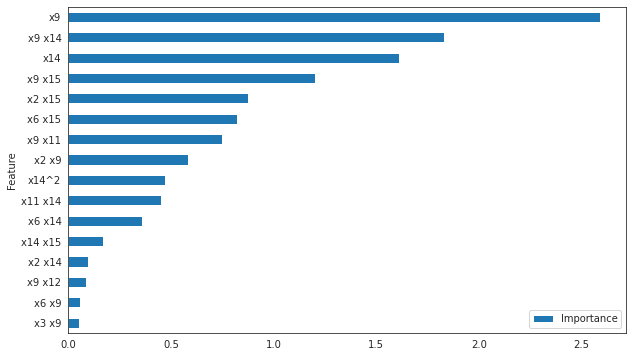

In [95]:
features_names = X_train_scalled.columns[selector.get_support(indices=True)]
X_train_new = X_train_scalled[list(features_names)]
X_test_new = X_test_scalled[list(features_names)]

model.fit(X_train_new, y_train)

coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Отобрали 16 наиболее важных признаков из всех, построили график важности признаков обученной модели SVC и отсортировали признаки по убыванию значимости. Наиболее важные 7, 12 и их комбинация. Менее важные 7и10, 1и7 и 12с13, их вклад наименьший их топ 16
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
По новой отобрали 16 наиболее важных признаков из всех, построили график важности признаков обученной модели SVC и отсортировали признаки по убыванию значимости. Наиболее важные 9, 14 и их комбинация. Менее важные 3и9, 6и9 и 9с12, их вклад наименьший из топ 16
</div>

<AxesSubplot:ylabel='Feature'>

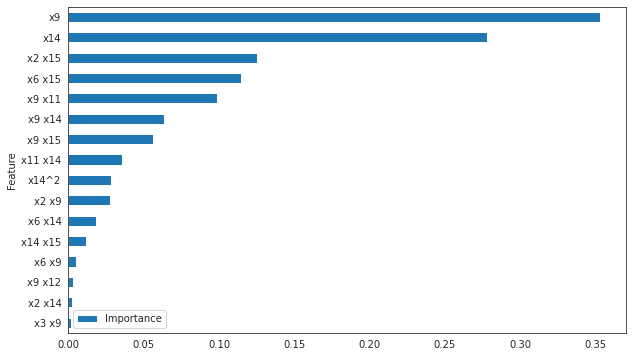

In [96]:
def custom(model, X, y):
    y_pred = model.predict(X)
    score = roc_auc_score(y, y_pred)
    return score

result = permutation_importance(model, X_test_new, y_test, scoring=custom)

feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) 

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Построили еще  график важности признаков обученной модели SVC и отсортировали признаки по убыванию значимости.
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Признаки 9 и 14 показали наибольшую важность, комбинации 9и11 и 6и15 показали себя чуть хуже, 3и9, 9и12 и 2и14 показали себя хуже всего из топ 16, почти не вносят вклада
</div>


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
построим график общей значимости признаков:
</div>

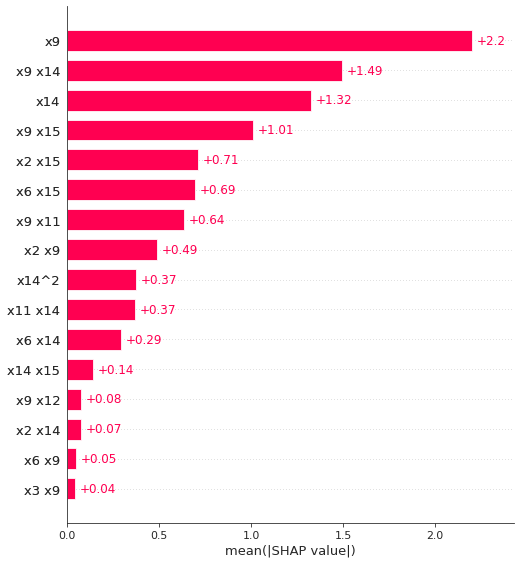

In [97]:
explainer = shap.LinearExplainer(model, X_test_new)
shap_values = explainer(X_test_new)
shap.plots.bar(shap_values, max_display=17) 


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Как и ранее 9 и 14 признаки выделяются на фоне остальных, а аутсайдеры сохранили свои позиции
</div>

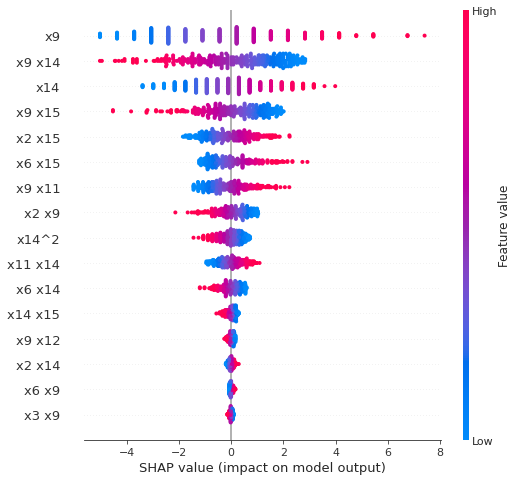

In [98]:
shap.plots.beeswarm(shap_values, max_display=16) 


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
   Видим, влияние признаков на предсказание, т.е. чем больше посещенно страниц и проведено времени, тем больше шанс, что активность клиента не снизится, но их комбинация т.е если клиент проводит много времени и посещает много страниц одновременно, наоборот несет в себе риск снижения активности.
    Для повышения активности можно рассмотреть вариант улучшения/добавления рекомендаций для клиентов, это поможет не посещать лишние страницы, а только нужные, что одновременно может повысить посещаемость страниц и проведенного времени для клиентом с низкими показателями и понизить с высокими показателями. Так же хороший вариант улучшить навигацию сайта, чтобы клиенты легче находили необходимые им товары, увеличение ассортимента так же может помочь
</div>

## Сегментация


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
   Прошу прощение, случайно удалил ваш комментарий по поводу сегментации, попробую сделать повторно по памяти :(
</div>


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
  Нам необходимо выбрать один сегмент и проанализировать его, учитывая прошлые данные. Согласно учету важности признаков, повышенный риск понижения активности у клиентов, которые посещают мало страниц и имеют маленький показатель в прошлом месяце проведенного времени. Отберем таких клиентов
</div>

In [99]:
thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 20,endpoint=False)]
y_proba_log = model.predict_proba(X_train_new)[:,1]
values=[]
for i in thresholds:
    y_pred_log = []
    for j in y_proba_log:
        if j<i:
            y_pred_log.append(0)          
        else:
            y_pred_log.append(1) 
    predicts = pd.DataFrame(zip(y_pred_log, y_test,  X_test_scalled['x10'].tolist()),\
                        columns = ['y_pred', 'y_test', 'summ_'])
    TP = predicts[(predicts['y_pred']==1)&(predicts['y_test']==1)]['summ_'].sum()
    FP = predicts[(predicts['y_pred']==1)&(predicts['y_test']==0)]['summ_'].sum()
    money = TP-FP
    values.append(money)
    print('threshold: ', i, '   money: ',money) 


threshold:  0.1    money:  -7.236988097314756
threshold:  0.15    money:  -10.4598182903039
threshold:  0.19    money:  -8.197400831121692
threshold:  0.24    money:  -7.219806860814119
threshold:  0.28    money:  -5.909211517188528
threshold:  0.32    money:  -5.534595186971823
threshold:  0.37    money:  -7.578018276750216
threshold:  0.42    money:  -7.06439941008837
threshold:  0.46    money:  -5.752465932109868
threshold:  0.5    money:  -2.487244460002007
threshold:  0.55    money:  -2.3409894396594573
threshold:  0.6    money:  -3.234577173949636
threshold:  0.64    money:  -0.901320312191952
threshold:  0.68    money:  -1.5077505432086453
threshold:  0.73    money:  -3.5570879825315487
threshold:  0.77    money:  3.7424451273240216
threshold:  0.82    money:  10.659894912978338
threshold:  0.86    money:  10.355341663117088
threshold:  0.91    money:  11.230195516466585
threshold:  0.96    money:  -9.092061115847551


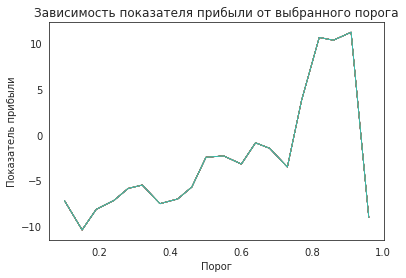

In [100]:
for i in thresholds:
    heatmap = sns.lineplot(x=thresholds, y=[i for i in values], size = 50, 
                    legend=False)
    plt.ylabel('Показатель прибыли')
    plt.xlabel('Порог')
    plt.title('Зависимость показателя прибыли от выбранного порога');

In [101]:
data = pd.DataFrame(zip(y_test, y_proba_log, X_test_scalled['x10'].tolist()),\
                        columns = ['y_test', 'y_proba', 'summ_'])
data.head()

,y_test,y_proba,summ_
0,False,0.981827,2.304809
1,True,0.815247,-2.173059
2,True,0.019115,-0.743318
3,True,0.167077,-0.842606
4,True,0.572622,0.011267


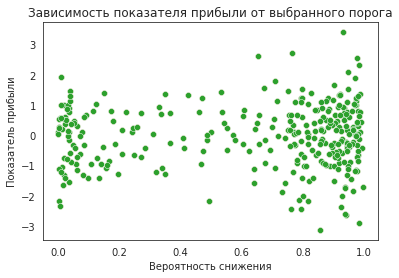

In [102]:
for i in data:
    heatmap_2 = sns.scatterplot(x=data['y_proba'], y=data['summ_']) 
    plt.ylabel('Показатель прибыли')
    plt.xlabel('Вероятность снижения')
    plt.title('Зависимость показателя прибыли от выбранного порога'); 


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
   Определили, что лучший показатель  threshold:  0.91  при таком показатели получилось сохранить самый большой показатель прибыли 11.2, отличной границей порога получится значение в 0.41, тк явно разбивает показатели на 2 куска
</div>

In [103]:
segment = X_train
segment['шанс_снижения'] = y_proba_log
segment.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,прибыль,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий,минут_текущий,шанс_снижения
0,стандарт,нет,5.7,4,565,0.14,домашний текстиль,5,1,4,12,2.60,5023.0,4252.0,3713.8,12,18,0.981827
1,стандарт,да,3.4,5,351,0.24,кухонная посуда,5,1,6,8,4.12,4949.0,4337.0,5000.0,15,13,0.815247
2,премиум,да,3.0,4,558,0.89,товары для детей,3,3,7,4,4.18,4715.0,5253.5,5633.1,8,9,0.019115
3,стандарт,да,3.1,4,152,0.33,косметика и аксесуары,6,4,2,5,5.70,4549.0,4254.0,4612.8,8,12,0.167077
4,стандарт,да,5.5,5,541,0.17,мелкая бытовая техника и электроника,4,1,6,5,6.78,5223.0,5388.0,5661.0,12,11,0.572622


In [104]:
segment = segment[segment['шанс_снижения'] > 0.41].reset_index(drop=True)
segment.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,прибыль,выручка_препредыдущий,выручка_предыдущий,выручка_текущий,минут_предыдущий,минут_текущий,шанс_снижения
0,стандарт,нет,5.7,4,565,0.14,домашний текстиль,5,1,4,12,2.60,5023.0,4252.0,3713.8,12,18,0.981827
1,стандарт,да,3.4,5,351,0.24,кухонная посуда,5,1,6,8,4.12,4949.0,4337.0,5000.0,15,13,0.815247
2,стандарт,да,5.5,5,541,0.17,мелкая бытовая техника и электроника,4,1,6,5,6.78,5223.0,5388.0,5661.0,12,11,0.572622
3,стандарт,нет,2.6,3,639,0.23,домашний текстиль,3,2,7,9,5.25,5030.0,4941.5,4994.8,14,15,0.655580
4,стандарт,нет,3.3,5,346,0.29,домашний текстиль,6,4,4,15,4.85,4409.0,4901.0,5457.4,8,12,0.957605


Среднее количество акционных покупок  0.2527326440177252


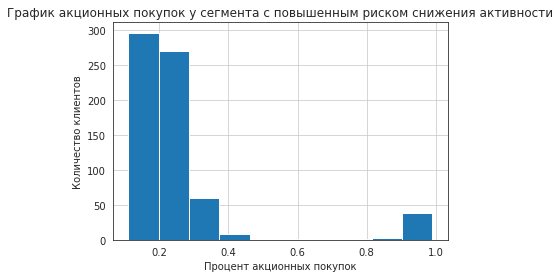

In [105]:
print('Среднее количество акционных покупок ', segment['акционные_покупки'].mean())
segment['акционные_покупки'].hist();
plt.ylabel('Количество клиентов')
plt.xlabel('Процент акционных покупок')
plt.title('График акционных покупок у сегмента с повышенным риском снижения активности'); 

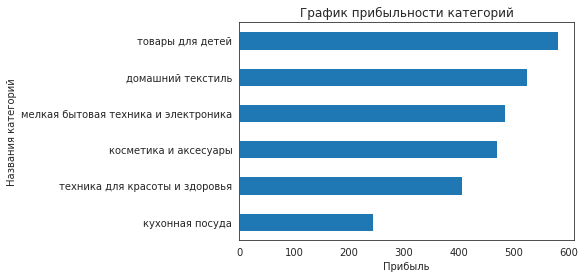

In [106]:
segment.groupby("популярная_категория")["прибыль"].sum().sort_values().plot(kind="barh", fontsize=10)
plt.ylabel('Названия категорий')
plt.xlabel('Прибыль')
plt.title('График прибыльности категорий'); 

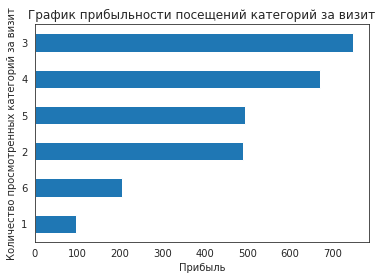

In [107]:
segment.groupby("средний_просмотр_категорий_за_визит")["прибыль"].sum().sort_values().plot(kind="barh", fontsize=10)
plt.ylabel('Количество просмотренных категорий за визит')
plt.xlabel('Прибыль')
plt.title('График прибыльности посещений категорий за визит'); 

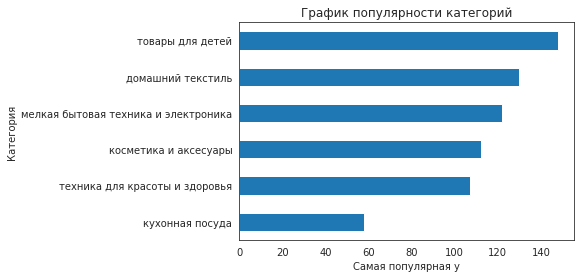

In [108]:
segment.groupby("популярная_категория")["популярная_категория"].count().sort_values().plot(kind="barh", fontsize=10)
plt.ylabel('Категория')
plt.xlabel('Самая популярная у')
plt.title('График популярности категорий'); 

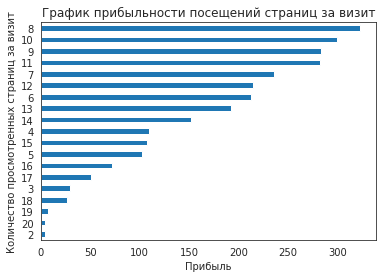

In [109]:
segment.groupby("страниц_за_визит")["прибыль"].sum().sort_values().plot(kind="barh", fontsize=10)
plt.ylabel('Количество просмотренных страниц за визит')
plt.xlabel('Прибыль')
plt.title('График прибыльности посещений страниц за визит'); 

Среднее количество акционных покупок  0.2527326440177252


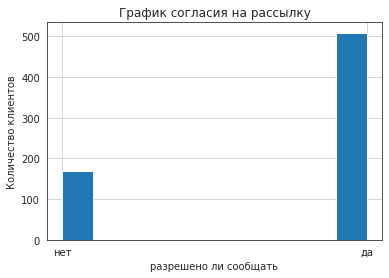

In [110]:
print('Среднее количество акционных покупок ', segment['акционные_покупки'].mean())
segment['разрешить_сообщать'].hist();
plt.ylabel('Количество клиентов')
plt.xlabel('разрешено ли сообщать')
plt.title('График согласия на рассылку'); 


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
   Как визит, сегмент, который с повышенных риском снизит активность, не часто покупает товары по акции, чаще всего покупают товары для детей. В среднем посещают 9-11 страниц из 3 категорий, хорошим решением для их удержания будет предоставление персональных предложений в рассылке, особые акции или условия, например выдача промокодов для их любимых категорий, прибыль это не сильно уменьшит, но поможет сохранить клиентов, как тех, кто не пользуется скидками, так и тех кто покупает только по скидке, ведь придется что-то сделать/купить, чтобы получить выгодную акцию. Так же улучшить рекомендованные товары на основе истории покупок.
</div>


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
Понимаю, что сегментация недоделана, но честно говоря написал что-то на основе воспоминаний о вашем комментарии, тк не совсем понимаю, что требуется :) Надеюсь все сделал правильно, спасибо вам за вашу работу!
</div>

## Общий вывод


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
    <ul><div>Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений..</div><br>
<div>Отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.</div><br></ul>
    <ul>Получили 4 исходные таблицы провели их предобратку (убрали дубликаты и пропуски, переименовали столбцы, поменяли типы данных, так же избавились от неявных дубликатов), после чего объединили данные по id клиента в одну большую таблицу, с которой в последствие стали работать. С ней мы провели корреляционный анализ, провели данные на мультикорреляцию</ul>
    <ul>Следующим шагом стало построение пайплайна для поиска наилучшей модели. Построил один общий пайплайн, в котором рассматривались несколько вариантов обработки количественных и качественных признаков, 4 модели с несколькими вариантами гиперпараметров, метрикой оценки была выбрана accuracy из-за того, что нам важен общий результат. Это все помогло нам найти наилучшую модель SVC параметром degree=1</ul>
    <ul>Проанализировали ценность и вклад признаков на работу модели, заглянули в ее черный ящик. Что позволило нам понять что наиболее важными признаками являются количество страниц за визит и проведенное время в прошлом месяце</ul>
    <ul>На основе этих данных разбили данные на 3 сегмента: активные, неактивные и спорные. Провели анализ сегмента спорные, которые по своей сути являются целевыми клиентами, на них стоит ориентироваться. У них мало неоплаченных товаров, хороший показатель прибыли и выручка с них растет каждый месяц. Самые популярные категории среди них домашний текстиль и товары для детей</ul>
    <ul>Для улучшения качества работы и сохранения клиентов стоит:
        <li>Улучшить качество/добавить рекомендацию страниц товаров по популярным категориям</li>
         <li>Добавить акционные предложения в популярные категории, так как их процент акционных покупок мал</li>
         <li>Расширить ассортимент</li>
         <li>Улучшить навигацию по сайту, чтобы легче было находить необходимый товар</li>
         <li>Добавить историю прошлых покупок товаров</li>
    </ul>
    
</div>